# <font color='white'><span style='background:green'> ***_P10 : ORGANISATION NATIONALE DE LA LUTTE CONTRE LE FAUX-MONNAYGE (ONCFM) - TG_*** <span><br><br>

In [1]:
# Librairies pour les dataframes et les calculs
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import scipy.stats as st
from scipy.stats import t, shapiro

# Librairies pour les graphiques
import matplotlib.pyplot as plt
import seaborn as sns


# Librairies pour la régression linéaire
#from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Librairie la régression logistique
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Librairie pour le K-mean et PCA
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Messages d'erreurs
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Classe couleur pour l'affichage
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
# Chargement des données
data = pd.read_csv('billets.csv', sep = ';',)

# <font color='darkcyan'>***I - ANALYSE DESCRIPTIVE DES DONNEES*** <br>

In [4]:
# Aperçu du dataframe
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [5]:
# Inforamtions sur les données
# Description des données
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:
# Identification des lignes ayant des donnees manquantes:
print(color.BOLD, data.index[data.isnull().any(axis=1)])
print(color.BOLD, data.isna().sum())

 Int64Index([  72,   99,  151,  197,  241,  251,  284,  334,  410,  413,  445,
             481,  505,  611,  654,  675,  710,  739,  742,  780,  798,  844,
             845,  871,  895,  919,  945,  946,  981, 1076, 1121, 1176, 1303,
            1315, 1347, 1435, 1438],
           dtype='int64')
 is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


### <span style='font-family:serif'><font color='darkcyan'> *Nous avons des données manquantes pour <font color='blue'>margin_low<font color='darkcyan'>(Valeurs nulles : <font color='red'>37<font color='darkcyan'>), il s'agit de la marge entre le bord inferieur du billet et l'image de celui-ci (en mm).<br> Procédons à <font color='darkslateblue'>une regression linéaire <font color='darkcyan'>pour les comblées afin de ne pas perdre trop d'information.<br><font color='skyblue'>PS: Notons que ces valeurs peuvent aussi être calculés à partir des valeurs du côté opposé des billets ou grace au théorème de Pythagore (En supposant que l'angle fasse 90°).*

## <span style='font-family:serif'><font color='lateorange'> *Régression linéaire (Multiple):*

### <span style='font-family:serif'><font color='red'>*Définition : <font color='green'>La régression linéaire multiple repose sur le même principe que la régression linéaire simple mis à part qu'elle utilise plus d'une variable explicative (dite indépendante) pour déterminer un résultat (la variable dite expliquée). Ce dernier est toujours continue alors que les variables explicatives peuvent êtres continues ou catégorielles. L'objectif reste le même : réaliser des prédictions.*<br>

In [7]:
# Créer un dataframe sans les lignes  Nan et la colonne "is_genuine"
df = data.dropna().drop("is_genuine", axis=1)
df

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


In [8]:
# Séparer les données de la colonne "margin_low" 
X = df.drop("margin_low", axis = 1).values
y = df["margin_low"]

In [9]:
# Creation de X_train et Y_train:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [10]:
# Régression linéaire
lr = LinearRegression()
# Adaptation sur les données entrainement
model_lr = lr.fit(X_train,y_train)

In [11]:
# Prédiction
y_pred = lr.predict(X_test)

In [12]:
# Calcul des résidus
residus = y_test - y_pred
residus

24      0.037547
514    -0.179688
1080    0.632941
1218    0.122311
1048    0.917491
          ...   
343    -0.210932
902    -0.567040
80      0.928847
1031    1.706043
205    -0.276126
Name: margin_low, Length: 366, dtype: float64

In [13]:
# Validaton du model(Après avoir construit le model, il est important de valider ces performences)

# Instanciation:
reg_lin = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = data)

# Calculs:
res_lin = reg_lin.fit()
#print(color.BOLD + color.BLUE , res_lin.summary())


Moyenne d'erreur de la prédiction est de R²= 0.4608709138121222 %


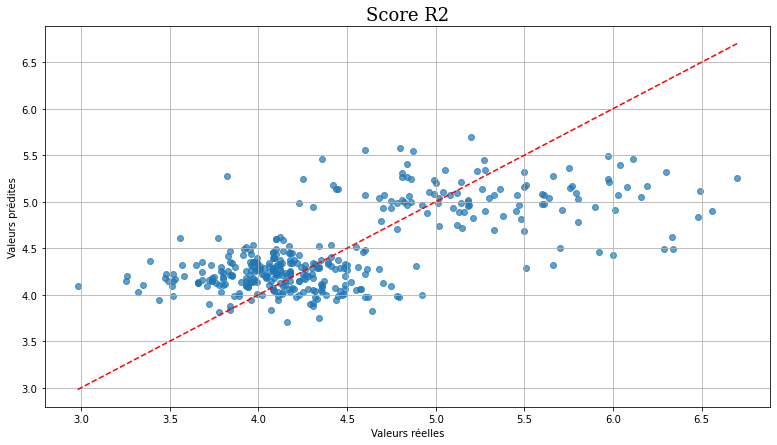

In [14]:
# le score R2 : la moyenne de la variable à prédire
print(color.BOLD + color.BLUE + "\nMoyenne d'erreur de la prédiction est de R²=" 
      + color.RED , r2_score(y_test,y_pred), color.BLUE + "%")

# Représentation Graphique
plt.subplots(figsize = (13,7))
plt.scatter(y_test,y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Score R2', fontname='Serif', fontsize=18)
plt.grid()
plt.show()

### <span style='font-family:serif'><font color='green'>*C'est est la partie de la variation totale de la variable dépendante qui est expliquée par la variation de la variable indépendante.<font color='darkcyan'><br>Le R² score (R-squared) <font color='darkslateblue'> n'est pas satisfaisant (inférieur à 0,5). <br><font color='darkcyan'> Un coefficient de determination (R²) faible indique simplement que l'ajustement linéaire n'est pas opportun. Cela n'indique pas forcément qu'il n'y a pas de relation entre Y et les p variables considérés.*

### <span style='font-family:serif'><font color='purple'>*Test de linéarité*

In [15]:
# La moyenne des residus est nulle:
print(color.BOLD + color.BLUE + "Moyenne des résidus = " + color.RED , residus.mean() , color.BLUE 
      + ". Elle est très proche de 0")
print(color.BOLD + color.DARKCYAN + "On considère donc que l'hypothèse de la linéarité est validé.\n")

Moyenne des résidus =  -0.00011110439671111933 . Elle est très proche de 0
On considère donc que l'hypothèse de la linéarité est validé.



### <span style='font-family:serif'><font color='purple'>*Test de colinéarité*

In [16]:
# Vérifier la colinéarité des variables
variables = res_lin.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686302,
 1.138260573608248,
 1.2301145155560367,
 1.4044037781843626,
 1.5769501453665806]

### <span style='font-family:serif'><font color='darkslateblue'>*Tous les coefficients sont inférieurs à 10, donc <font color='darkcyan'>pas de problème de colinéarité.*<br>

### <span style='font-family:serif'><font color='purple'>*Test de l'homoscédasticité*

Test de Breusch Pagan: p value = 7.759535216275702e-16
La P-valeur ici est inférieur à 5%, on ne rejette pas l'hypothèse HO. Les variances sont constantes (l'hypothèse d'homoscédasticité est vérifiée)


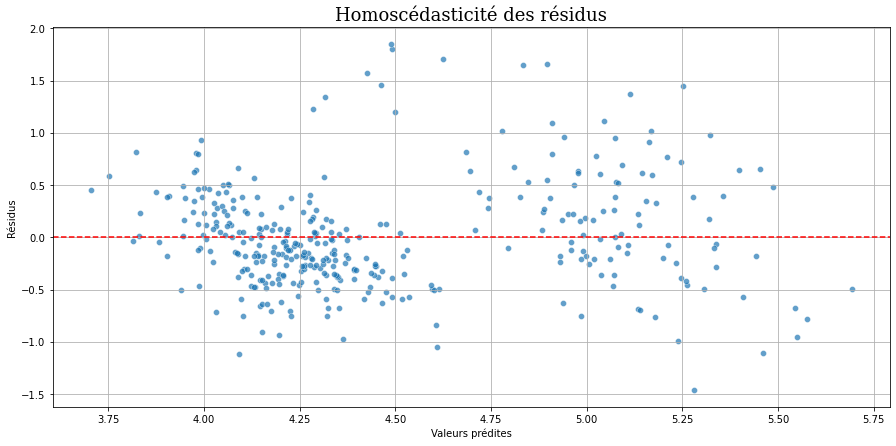

In [17]:
# Tester l'homoscédasticité (Test de Breusch Pagan)
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(res_lin.resid, variables)
print(color.BOLD + color.BLUE + 'Test de Breusch Pagan: p value =' + color.RED , pval)
print(color.BOLD + color.BLUE + "La P-valeur ici est inférieur à 5%, on ne rejette pas l'hypothèse HO." 
      + color.CYAN + " Les variances sont constantes (l'hypothèse d'homoscédasticité est vérifiée)")

# Représentation graphique (Homoscédasticité)
plt.subplots(figsize = (15,7))
sns.scatterplot(y_pred, residus, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Homoscédasticité des résidus', fontname='Serif', fontsize=18)
plt.grid()
plt.show()

### <span style='font-family:serif'><font color='darkslateblue'>*la répartition est assez aléatoire ici. La P-value est très inférieure au seuil (alpha = 5%), l'hypothèse nulle d'homoscédasticité n'est donc pas rejeté. <font color='darkcyan'>L'hypothèse d'homoscédasticité de notre régression linéaire est donc vérifiée au risque de 5% (alpha).*<br>

### <span style='font-family:serif'><font color='purple'>*Test de normalité*

Test de Shapiro-Wilk: 
 ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)


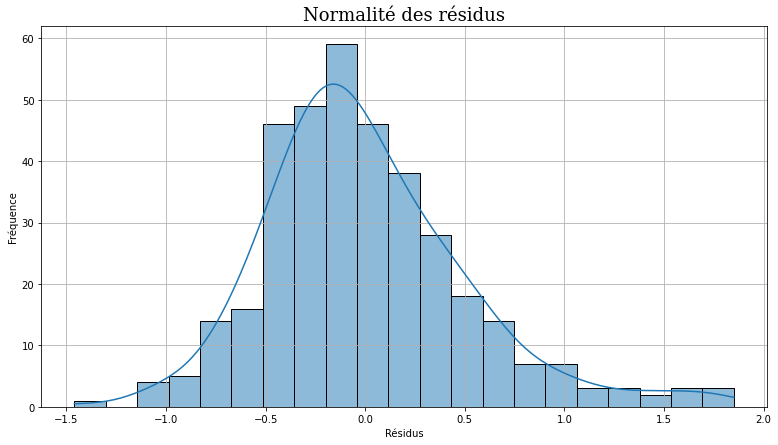

In [18]:
# Test de Shapiro pour la normalité des résidus
print(color.BOLD + color.BLUE + color.UNDERLINE + "Test de Shapiro-Wilk: \n" 
      + color.END + color.BOLD + color.RED, shapiro(res_lin.resid))

# Normalité des résidus (Représentation graphique)
plt.subplots(figsize = (13,7))
sns.histplot(residus, alpha=0.5, kde=True)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Normalité des résidus', fontname='Serif', fontsize=18)
plt.grid()
plt.show()

### <span style='font-family:serif'><font color='darkslateblue'>*D'après le graphe, les résidus semblent suivre une distribution Normale. Le test de shapiro-wilk, lui, remet en question l'hypothèse de normalité (p-value<0,05).<br> Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes (même si le résidu n'est pas considéré comme étant gaussien).*<br>

In [19]:
# Aperçu des prédictions
y_pred[:10]

array([4.14245336, 4.23968751, 4.97705899, 5.13768935, 5.16250872,
       4.27059135, 4.96001504, 3.83054924, 4.99126889, 4.45428343])

In [20]:
# Aperçu des résultats du Test
y_test[:10]

24      4.18
514     4.06
1080    5.61
1218    5.26
1048    6.08
402     4.12
1231    4.84
279     3.84
1201    4.86
332     4.08
Name: margin_low, dtype: float64

> ### <font color='lateorange'> ***Prédiction des valeurs nulls (margin_low):***

In [21]:
# Créer un df avec les margin_low nulls (sans la colonne is_genuine et margin_low)
df_na = data[data["margin_low"].isna()].drop(["is_genuine","margin_low"], axis=1)

# Appliquer la prédiction sur df_na (les margin_low nulls)
df_na["margin_low"] = lr.predict(df_na)

# Aperçu du df après la prédiction 
df_na.head()

,diagonal,height_left,height_right,margin_up,length,margin_low
72,171.94,103.89,103.45,3.25,112.79,4.319619
99,171.93,104.07,104.18,3.14,113.08,4.396021
151,172.07,103.80,104.38,3.02,112.93,4.413697
197,171.45,103.66,103.80,3.62,113.27,4.313978
241,171.83,104.14,104.06,3.02,112.36,4.647477


In [22]:
# Concatenation pour avoir le résultat dans le data sans le margin_low
lr_result = [df,df_na]
data2 = pd.concat(lr_result)

# Arrondir de 2 chiffre après la virgule
data2["margin_low"] = data2["margin_low"].round(2)
data2

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1303,172.17,104.49,103.76,5.04,2.93,111.21
1315,172.08,104.15,104.17,4.77,3.40,112.29
1347,171.72,104.46,104.12,5.70,3.61,110.31
1435,172.66,104.33,104.41,5.18,3.56,111.47


In [23]:
# Fusion avec le data initiale pour inclure la colonne is_genuine
data_f = data.merge(data2, on=["diagonal","height_left","height_right","margin_up"], how='left')

# Supprimer les colonnes margin_low_x (avec les nan) et length_y (=lenght_x)
data_f = data_f.drop(["margin_low_x","length_y"], axis=1)

# Renomer les colonnes length_x et margin_low_y
data_f.rename(columns ={"length_x":"length", "margin_low_y": "margin_low"}, inplace= True)

# Remettre la colonne margin_low à sa place
new_index = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up',
             'margin_low','length']
data_f = data_f.reindex(columns=new_index)

data_f

,is_genuine,diagonal,height_left,height_right,margin_up,margin_low,length
0,True,171.81,104.86,104.95,2.89,4.52,112.83
1,True,171.46,103.36,103.66,2.99,3.77,113.09
2,True,172.69,104.48,103.50,2.94,4.40,113.16
3,True,171.36,103.91,103.94,3.01,3.62,113.51
4,True,171.73,104.28,103.46,3.48,4.04,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,3.09,4.42,111.28
1496,False,172.19,104.63,104.44,3.37,5.27,110.97
1497,False,171.80,104.01,104.12,3.36,5.51,111.95
1498,False,172.06,104.28,104.06,3.46,5.17,112.25


In [24]:
# Vérification des valeurs nulls : RAS
#data_f.isna().sum()

In [25]:
# Vérification des informations: RAS
data_f.info()
data_f.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   margin_low    1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


,diagonal,height_left,height_right,margin_up,margin_low,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,3.151473,4.483507,112.67850
std,0.305195,0.299462,0.325627,0.231813,0.659483,0.87273
min,171.040000,103.140000,102.820000,2.270000,2.980000,109.49000
25%,171.750000,103.820000,103.710000,2.990000,4.020000,112.03000
50%,171.960000,104.040000,103.920000,3.140000,4.310000,112.96000
75%,172.170000,104.230000,104.150000,3.310000,4.870000,113.34000
max,173.010000,104.880000,104.950000,3.910000,6.900000,114.44000


> ### <font color='lateorange'> ***Quelques représentations en fonction des vrais et des faux (is-genuine) :***

In [26]:
# Valeurs de 'is_genuine'
data_f['is_genuine'].unique()

array([ True, False])

In [27]:
# Regroupons tous les vrais
vrais = data_f.loc[data_f['is_genuine'].isin([True]),:]
vrais # 1000

,is_genuine,diagonal,height_left,height_right,margin_up,margin_low,length
0,True,171.81,104.86,104.95,2.89,4.52,112.83
1,True,171.46,103.36,103.66,2.99,3.77,113.09
2,True,172.69,104.48,103.50,2.94,4.40,113.16
3,True,171.36,103.91,103.94,3.01,3.62,113.51
4,True,171.73,104.28,103.46,3.48,4.04,112.54
...,...,...,...,...,...,...,...
995,True,171.66,103.92,103.47,2.83,4.26,113.20
996,True,172.16,103.72,103.61,2.72,4.30,113.51
997,True,171.78,103.38,104.22,3.07,4.23,113.77
998,True,171.44,103.96,103.92,2.89,3.68,113.21


In [28]:
# Regroupons tous les faux
faux = data_f.loc[data_f['is_genuine'].isin([False]),:]
faux # 500

,is_genuine,diagonal,height_left,height_right,margin_up,margin_low,length
1000,False,172.28,103.95,103.91,3.31,4.78,111.40
1001,False,171.92,103.86,104.30,3.13,4.96,111.29
1002,False,171.59,104.14,104.38,3.47,4.97,111.22
1003,False,172.02,104.33,104.33,3.21,5.19,111.99
1004,False,172.55,104.25,104.23,3.13,5.60,111.72
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,3.09,4.42,111.28
1496,False,172.19,104.63,104.44,3.37,5.27,110.97
1497,False,171.80,104.01,104.12,3.36,5.51,111.95
1498,False,172.06,104.28,104.06,3.46,5.17,112.25


In [29]:
# Moyenne celon l'authenticitée (par "is_genuine")
data_f.groupby(by='is_genuine').mean()

,diagonal,height_left,height_right,margin_up,margin_low,length
is_genuine,,,,,,
False,171.90116,104.19034,104.14362,3.35016,5.21388,111.63064
True,171.98708,103.94913,103.80865,3.05213,4.11832,113.20243


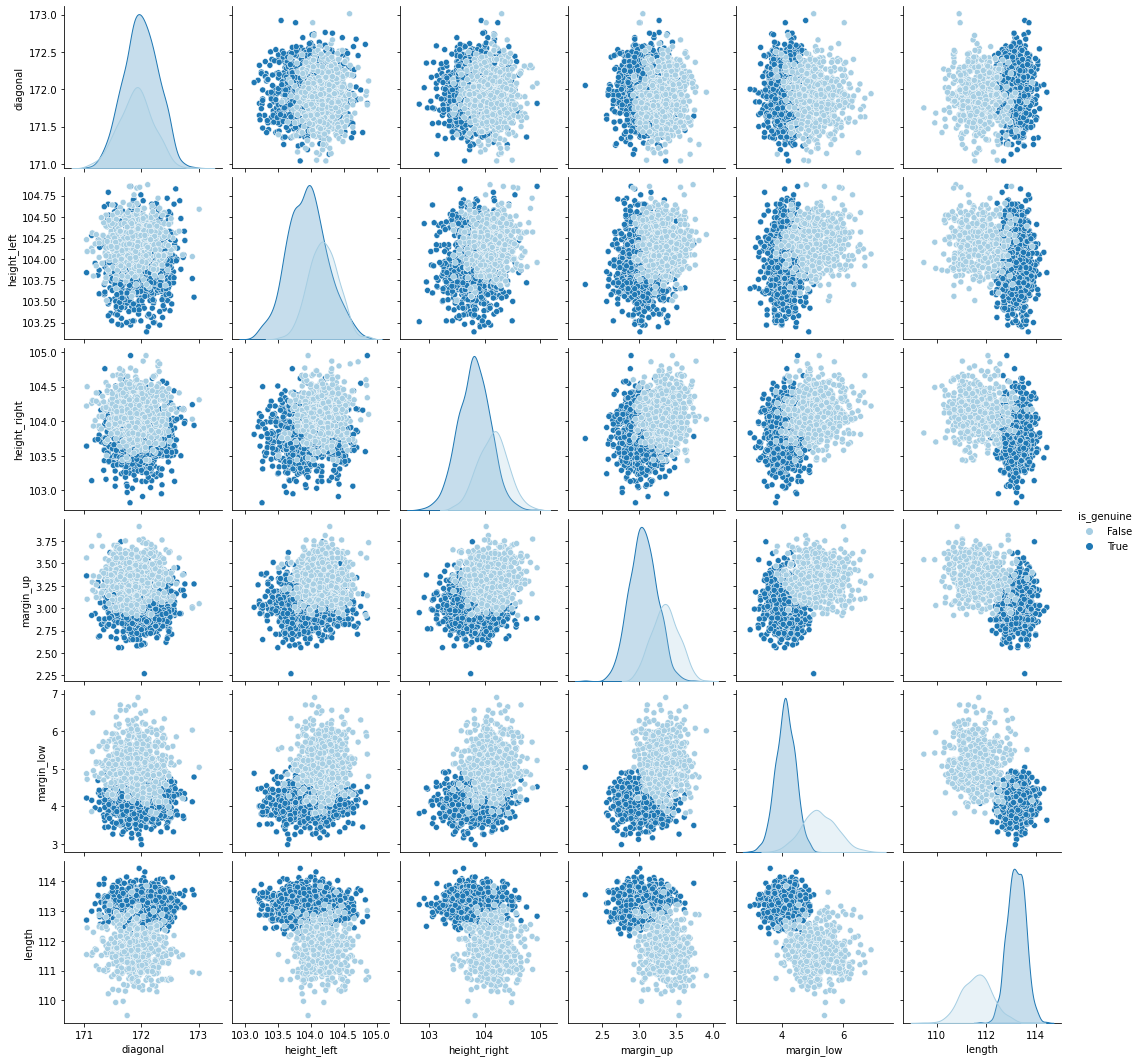

In [30]:
# Représentation pair plot
sns.pairplot(data_f, hue="is_genuine", palette="Paired")
plt.show()

### <span style='font-family:serif'><font color='darkslateblue'>*Les dimensions qui nous permettent vraiment de distinguer les vrais des faux billets sont "length" et "margin_low". Les densités sur la diagonale ne se recouvrent que très peut.*<br>

In [31]:
# Compter le nombre de valeur pour notre target
print(color.BOLD + color.BLUE, data_f.iloc[:,0].value_counts(), "\n")

# Pourcentage de valeur pour notre target
print(color.BOLD + color.BLUE, data_f.iloc[:,0].value_counts(normalize=True).round(2), "\n")

 True     1000
False     500
Name: is_genuine, dtype: int64 

 True     0.67
False    0.33
Name: is_genuine, dtype: float64 



             diagonal  height_left  height_right  margin_up  margin_low  length
is_genuine                                                                    
False            500          500           500        500         500     500
True            1000         1000          1000       1000        1000    1000


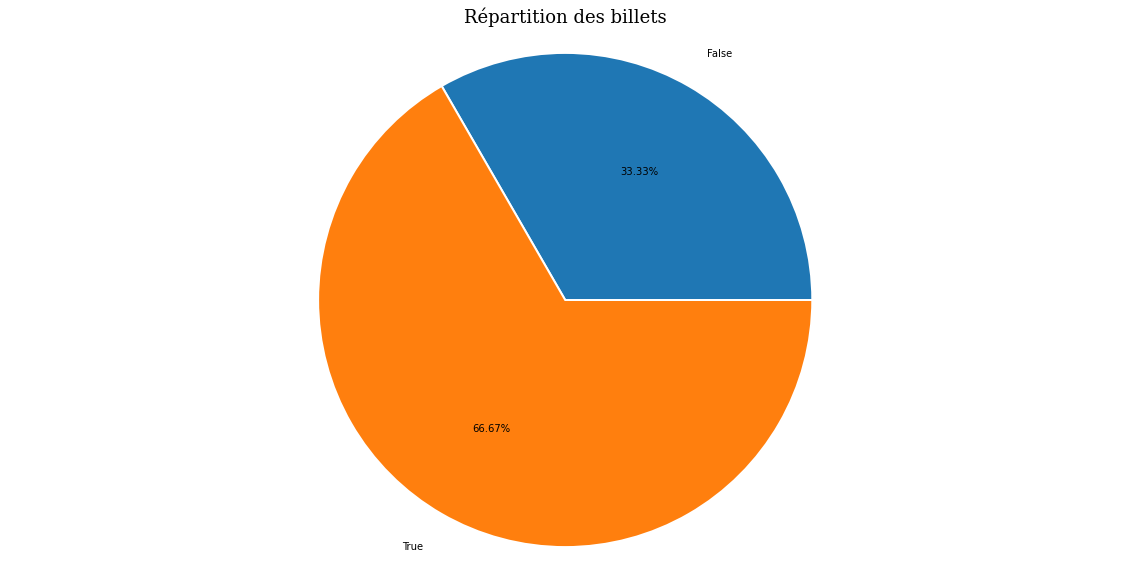

In [32]:
# Repartition des vrais/faux billets dans notre dataset d'apprentissage:
print(color.BOLD + color.GREEN , data_f.groupby(["is_genuine"]).count())

# Graphique:
fig1, ax1 = plt.subplots(figsize=(20,10))
ax1.pie(data_f.groupby(["is_genuine"])["diagonal"].count(),
        labels=["False","True"],
        labeldistance=1.15,
        wedgeprops= {'linewidth' : 2, 'edgecolor' : 'white'},
        autopct="%1.2f%%")
ax1.axis("equal")
plt.title("Répartition des billets", fontname='Serif', fontsize=18)
#plt.legend()
plt.show()

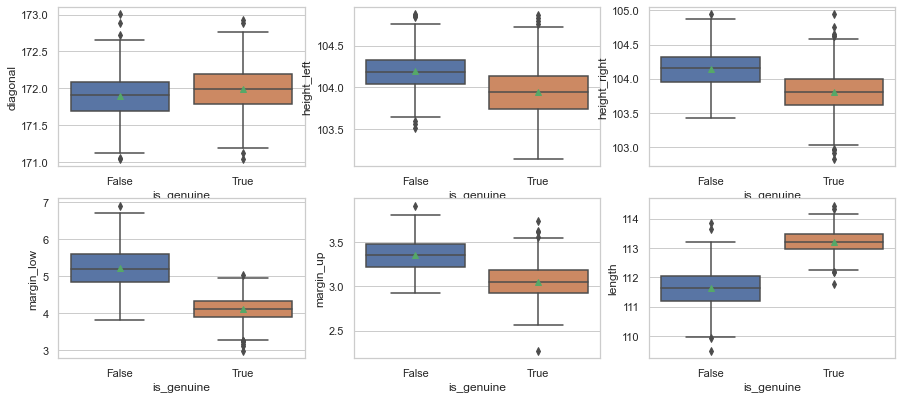

In [33]:
# Distribution entre les is_genuine et les variables
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")

plt.subplot(331)
sns.boxplot(x='is_genuine', y='diagonal', data= data_f, showmeans=True)
plt.subplot(332)
sns.boxplot(x='is_genuine', y='height_left', data= data_f, showmeans=True)
plt.subplot(333)
sns.boxplot(x='is_genuine', y='height_right', data= data_f, showmeans=True)
plt.subplot(334)
sns.boxplot(x='is_genuine', y='margin_low', data= data_f, showmeans=True)
plt.subplot(335)
sns.boxplot(x='is_genuine', y='margin_up', data= data_f, showmeans=True)
plt.subplot(336)
sns.boxplot(x='is_genuine', y='length', data= data_f, showmeans=True)

plt.show()

### <span style='font-family:serif'><font color='darkslateblue'>*On peut voir qu'il y a, pour chaque dimension, quelques valeurs un peu aberrantes. <font color='darkcyan'>Mais nous allons les garder pour la régression logistique. <font color='darkslateblue'>Nous ne savont pas comment elles se comportent, et les supprimer pourrait fausser nos résultats.*<br>

# <font color='darkcyan'>***II - K-Means (Clustering)*** <br>

In [34]:
# Copy du data final
datak = data_f.copy()
datak.head()

,is_genuine,diagonal,height_left,height_right,margin_up,margin_low,length
0,True,171.81,104.86,104.95,2.89,4.52,112.83
1,True,171.46,103.36,103.66,2.99,3.77,113.09
2,True,172.69,104.48,103.50,2.94,4.40,113.16
3,True,171.36,103.91,103.94,3.01,3.62,113.51
4,True,171.73,104.28,103.46,3.48,4.04,112.54


In [35]:
# Séparation les données
X = datak.drop(['is_genuine'],axis=1).values
y = datak['is_genuine']

In [36]:
# Indexer sur is_genuine
#datak.set_index('is_genuine',inplace=True)

In [37]:
# Division des données (entrainements et tests)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

> ### <font color='lateorange'> ***Méthode du coude***

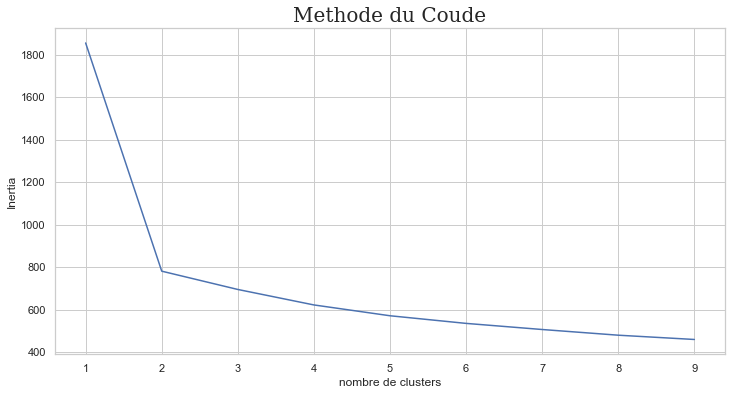

In [38]:
# Methode de la Coude

# Liste vide pour stocker nos inertie
intertia = []

# Liste de nombre de clusters qu'on veut tester
k_list = range(1, 10)
#list(k_list)

# Pour chaque valeur de k, on entraine un k-means spécifique et on stocke son inertie :
for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X_train) 
  intertia.append(kmeans.inertia_)
#intertia

# Affichage
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, intertia)

plt.title("Methode du Coude", fontname='Serif', fontsize=20)
plt.xlabel("nombre de clusters")
plt.ylabel("Inertia")
#plt.grid()
plt.show()

### <span style='font-family:serif'><font color='blue'>*On voir ici que l’inertie commence stagner à partir de 2 clusters.<br><font color='darkcyan'> Nous allons bien sûr faire un découpage en 2 clusters K-means.<font color='blue'>On aurait pu se passer de cette methode car ici on ne cherche qu'avoir 2 résultats (Vrai ou faux)*<br>

In [39]:
# On enregistre nos axes x, y
x, y = axis = (0,1)

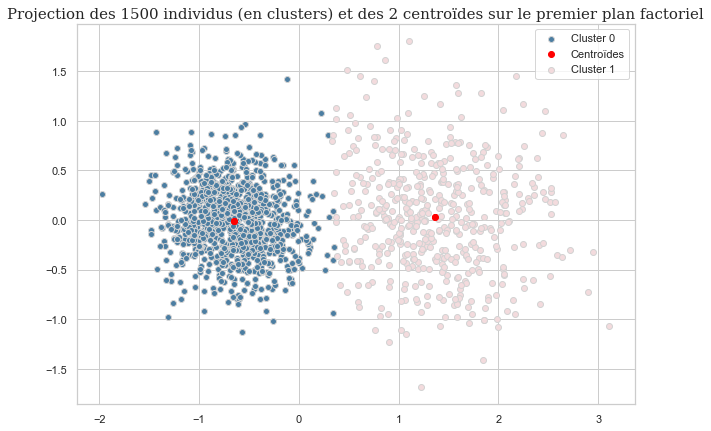

In [40]:
# Nombre de clusters:
n_clust = 2

# Clustering par K-means:
km = KMeans(n_clusters=n_clust,random_state=1994)
x_km = km.fit_transform(datak[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

# Ajout du cluster attribue:
clusters_km = km.labels_

# Centroïdes
centroids_km = km.cluster_centers_

# Clustering par projection des individus sur le premier plan factoriel (byTG):
pca_km = decomposition.PCA(n_components=3).fit(datak[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=3).fit_transform(datak[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)

# Graphique:
plt.subplots(figsize = (10,7))
for couleur,k in zip(["#4c7ea2","#f3dbdd"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],
                acp_km[km.labels_==k,1],
                c=couleur,edgecolors="#D3D3D3",
                label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],
                centroids_km_projected[:,1],
                color="red",label="Centroïdes")

plt.title("Projection des 1500 individus (en clusters) et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)),
          fontname='Serif', fontsize=15)
plt.show()

In [41]:
# Créer colonne cluster_kmeans
datak["cluster_kmeans"] = clusters_km
#datak

In [42]:
#datak["cluster_kmeans"].unique()

In [43]:
# Cluster 0
cluster0 = datak.loc[datak["cluster_kmeans"]==0]
#cluster0 # 1016

In [44]:
# Les faux dans le cluster 0
#cluster0.loc[cluster0.index==False] # 19 faux-vrais

### <span style='font-family:serif'><font color='darkslateblue'>*Le clusters 0 contient 1016 billets dont 19 faux. <font color='darkcyan'>C'est donc le cluster des vrais billets*<br>

In [45]:
# Les clusters 1
cluster1 = datak.loc[datak["cluster_kmeans"]==1]
#cluster1 # 484

In [46]:
# Les vrais dans le cluster 1
#cluster1.loc[cluster1.index==True] # 3 vrais dans les clusters de faux

### <span style='font-family:serif'><font color='darkslateblue'>*Le clusters 1 contient 484 billets dont 3 vrais.<font color='darkcyan'> C'est donc le cluster des faux billets*<br>

In [47]:
# Nombre de clusters:
#n_clust = 2

# Clustering par K-means:
#km = KMeans(n_clusters=n_clust,random_state=1994)
# Adapter avec les données d'entrainement
km.fit(X_train)

# Prédiction sur les données tests
label_test = km.predict(X_test)

In [48]:
# Matrice de confusion
cm = confusion_matrix(y_test, label_test)
#cm = pd.crosstab(y_test,label_test)
cm

array([[  4,  98],
       [198,   0]])

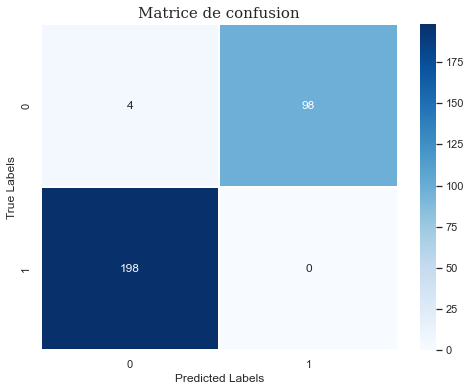

In [49]:
# Représentation matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linecolor="white", linewidths=0.3)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matrice de confusion', fontname='Serif', fontsize=15)
plt.show()

### <span style='font-family:serif'><font color='darkslateblue'>*Dans les données test (X_test), on a prédit pour  le cluster 0 (cluster des vrais) 198 billets vrais et 4 faux billets. Puis on a prédit pour  le cluster 1 (cluster des faux) 0 billet vrais et 98 faux billets*<br>

# <font color='darkcyan'>***III - Régression logistique*** <br>

### <span style='font-family:serif'><font color='red'>*Définition : <font color='green'>L’algorithme de régression logistique mesure la relation entre la variable dépendante catégorielle et une ou plusieurs variables indépendantes en donnant une estimation à la probabilité d’occurrence d’un événement à travers l’usage de sa fonction logistique.<br> <font color='darkcyan'>Il existe plusieurs types de régression logistique: binaire, mutlinomiale, ordinale. Ici, c'est la régression logistique binaire qui nous intéresse.*

### <span style='font-family:serif'><font color='darkslateblue'>*L'objectif, ici, est de mettre en place un modèle prédictif grace aux données annotées. Il s'agit d'expliquer une variable qualitative binaire (Vrai/Faux) par des variables quantitatives aléatoires (mesures en mm). D'où <font color='darkcyan'> la régression logistique<font color='darkslateblue'>(ici binaire : True ou False).*<br>

In [50]:
# Réindexer datak
#datak = datak.reset_index()
datak.head()

,is_genuine,diagonal,height_left,height_right,margin_up,margin_low,length,cluster_kmeans
0,True,171.81,104.86,104.95,2.89,4.52,112.83,0
1,True,171.46,103.36,103.66,2.99,3.77,113.09,0
2,True,172.69,104.48,103.50,2.94,4.40,113.16,0
3,True,171.36,103.91,103.94,3.01,3.62,113.51,0
4,True,171.73,104.28,103.46,3.48,4.04,112.54,0


In [51]:
# Séparation les données
X = datak.drop(['is_genuine','cluster_kmeans'],axis=1).values
y = datak['is_genuine']

In [52]:
# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [53]:
# Modélisation du modèle
logistic = LogisticRegression()
# Fit sur les données entrainement (adaptation)
logistic.fit(X_train, y_train)
# Prédiction sur les données test
y_pred = logistic.predict(X_test)
#y_pred

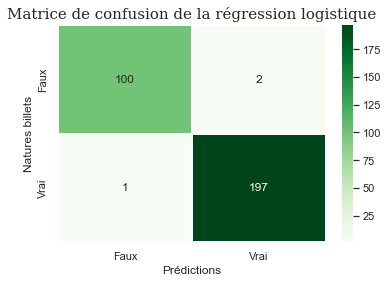

In [54]:
# Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred),
            cmap="Greens",annot=True, fmt=".3G",
            linecolor="white", linewidths=0.3, xticklabels=["Faux","Vrai"], yticklabels=["Faux","Vrai"])
plt.xlabel("Prédictions")
plt.ylabel("Natures billets")
plt.title("Matrice de confusion de la régression logistique", fontname='Serif', fontsize=15)
plt.show()

### <span style='font-family:serif'><font color='darkslateblue'>*Dans la prédiction des faux, il y a 1 billet vrai tandis qu'il a 100 billets qui sont véritablement faux...*<br>

In [55]:
# Pécision du modèle
print(color.BOLD + color.BLUE + "La performance du modèle: accuracy = " + color.RED,
      metrics.accuracy_score(y_test, y_pred)) # accuracy

La performance du modèle: accuracy =  0.99


## <span style='font-family:serif'><font color='lateorange'> *Test de la courbe de ROC:*

### <span style='font-family:serif'><font color='red'>*Définition : <font color='green'>Elle permet la détermination et la comparaison des performances diagnostiques de plusieurs tests à l'aide de l'évaluation des aires sous la courbe..*

In [56]:
#datak.head()

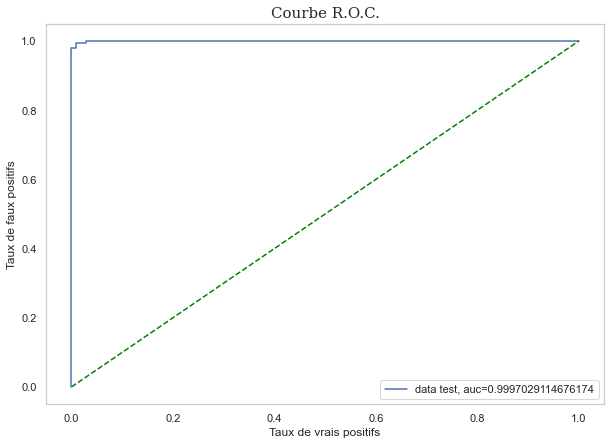

In [57]:
# Affichage de la courbe ROC 
y_pred_proba = logistic.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="data test, auc=" + str(auc))
plt.plot([0,1], [0,1], color='green', linestyle="--")
plt.title("Courbe R.O.C.",fontname='Serif', fontsize=15)
plt.xlabel("Taux de vrais positifs")
plt.ylabel("Taux de faux positifs")
plt.legend()
plt.grid()
plt.show()

### <span style='font-family:serif'><font color='darkcyan'>*On retombe sur un modèle quasiment parfait avec une aire sous la courbe approximée à 1.*<br>

> ### <font color='lateorange'> ***Enregistrement(sauvegarde) du modèle avec Pickel***

In [58]:
# importation de la librairie pickel
import pickle
# Enregistrement du model dans un fichier pickel
filename = 'logistic_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(logistic, file)

# <font color='darkcyan'>***IV - Applicaton de la prédiction*** <br>

> ### <font color='lateorange'> ***Tester sur un fichier exemple:***

In [59]:
# Importation du fichier exemple
exemple = pd.read_csv("billets_production.csv")
exemple

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [60]:
# Séparation les données
X = exemple.drop(['id'], axis=1).values

In [61]:
# Fermer le fichier
file.close()

In [62]:
# Désérialiser le fichier (Chargement)
with open('logistic_model.pkl', 'rb') as file:
    logistic_loaded = pickle.load(file)

In [63]:
# la probabilité obtentue
probabilites = logistic_loaded.predict(X)
probabilites

array([False, False, False,  True,  True])

In [64]:
# Créer un dataframe pour le résultat
resultat = pd.DataFrame({"ID":exemple['id'], 'Nature': probabilites})
resultat

,ID,Nature
0,A_1,False
1,A_2,False
2,A_3,False
3,A_4,True
4,A_5,True


In [65]:
print(color.BOLD + color.PURPLE + color.UNDERLINE +"\nIndetification des billets:\n"+ color.END)
for i, k in zip(resultat["Nature"],resultat["ID"]):
    if i == 1:
        print(color.BOLD + color.BLUE +"Le billet" + color.CYAN,"{}".format(k),
              color.BLUE + "est" + color.GREEN +" vrai")
    else:
        print(color.BOLD + color.BLUE +"Le billet" + color.CYAN,"{}".format(k), 
              color.BLUE + "est" + color.RED +" faux")


Indetification des billets:

Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


# <font color='white'><span style='background:green'> ***_P10.END_*** <span><br><br>

***